In [45]:
import re
import os
import csv
import datetime
import time
import pandas as pd
import numpy as np
import ipaddress
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10, 10)

import seaborn as sns
sns.set_style('darkgrid')

In [57]:
# shows percentage-completed bar    
def perc_write(curr_val, max_val):
    if curr_val % int(max_val / 10) == 0:
        print(round(curr_val / max_val * 10), end="")
        if round(curr_val / max_val * 10) == 10:
            print("")
    elif curr_val % int(max_val / 100) == 0:            
        print("-", end="")

def ip2long(ip):
    return int(ipaddress.ip_address(str(ip)))
    
def clean(string):
    return string.replace("]","").replace("[","").replace("'","").strip()

# Extracts all honeypot data
def extract_honey(folder):
    honey = []
    num_cols = 7
    print("Extracting honey. This will take a while..")
    files = os.listdir(honey_location)
    print("Total number of files:", len(files))
    for index, filename in enumerate(files):
        if "." not in filename: 
            continue
        print(index, filename)
        with open(honey_location + "/" + filename) as f:
            for row in f:
                row = row.split("$$")
                commands = clean(row[-1])[:300].split(",")
                login = []
                if len(commands[0]) < 20:
                    login = commands[0:2]
                    commands = commands[2:]
                honey.append(row[:len(row)-1])            
                honey[-1].append(login)          
                honey[-1].append(commands)
                if len(honey[-1]) > 7:
                    num_cols = len(honey[-1])
        print(honey[-1])
    print("Done.")
    return honey, num_cols

def honey_to_panda(honey, cols):
    print("Converting honey to panda.. ", end="")
    headers = ["Timestamp", "SrcIP", "SrcPort", "DstIP", "DstPort", "Login", "Commands"]
    if cols > 7:
        headers.append("lol")
    panda = pd.DataFrame(honey, columns=headers)[["Timestamp", "SrcIP", "SrcPort", "DstIP", "DstPort", "Login", "Commands"]]
    panda['Timestamp'] = pd.to_datetime(panda['Timestamp'],format="%Y-%m-%d %H:%M:%S")
    panda['SrcIP_I'] = panda.apply(lambda row: ip2long(row['SrcIP']), axis=1)
    panda['DstIP_I'] = panda.apply(lambda row: ip2long(row['DstIP']), axis=1)
    panda = panda.sort_values(['Timestamp', 'SrcIP_I', 'DstIP_I'], ascending=[True,True,True])
    print("Done.")
    return panda

def store_panda(path, panda):
    print("Storing panda.. ", end="")
    panda.to_csv(path, sep='\t', encoding='utf-8')
    print("Done.")

def load_panda(path):
    print("Loading panda.. ", end="")
    panda = pd.DataFrame.from_csv(path, sep='\t', encoding='utf-8')
    print("Done.")
    return panda

In [55]:
# Import the datasets (please use the provided csv's and place this in the folder of the notebook)
# First extract the source ip addresses from all data and store it (if not done before).
honey_location = "C:/Users/Rob/Downloads/two_month"
pandafile = "pandified_data.csv"
overwrite = False

if overwrite or not os.path.isfile(pandafile):
    honey, cols = extract_honey(honey_location)
    panda_data = honey_to_panda(honey, cols)
    store_panda(pandafile, panda_data)
else:
    panda_data = load_panda(pandafile)  

Loading panda.. Done.


In [56]:
print(panda_data.head(50))

#print("hoi")
df_ip = df[(df.SrcIP == '190.147.187.12')].sort_values(['DstIP', 'Timestamp'], ascending=[False,True])
#p = df[(df.Commands.map(len) >= 5)].sort_values(['DstIP', 'Timestamp'], ascending"lol"=[False,True])
#print(p["Commands"].iloc[0])
#df[('61.245.160.0' < df.ip) & (df.ip < '61.245.175.255')]

                 Timestamp            SrcIP  SrcPort           DstIP  DstPort  \
40028  2016-07-01 05:42:10   85.250.215.179    51310  133.34.157.111       23   
12092  2016-07-01 05:42:10    113.22.96.148    37268  133.34.157.114       23   
53995  2016-07-01 05:42:10    119.87.76.235     1289  133.34.157.152       23   
40953  2016-07-01 05:42:10    201.132.44.72    46124  133.34.157.113       23   
11317  2016-07-01 05:42:11   79.173.253.201    46565  133.34.157.141       23   
1424   2016-07-01 05:42:11   223.19.224.251    43532  133.34.157.122       23   
11087  2016-07-01 05:42:12   14.182.102.111    49781   133.34.157.83       23   
118    2016-07-01 05:42:12    62.219.98.132     1182  133.34.157.148       23   
38881  2016-07-01 05:42:12      106.1.80.81    48173   133.34.157.92       23   
25591  2016-07-01 05:42:12  201.206.191.114    44130  133.34.157.125       23   
54449  2016-07-01 05:42:12  221.151.203.120    37815  133.34.157.133       23   
14843  2016-07-01 05:42:13  

NameError: name 'df' is not defined

In [6]:
#print("hoi")
ipp = '115.177.11.215'

def write_srcip_data(panda_data, srcip, text):
    df_ip = df[(df.SrcIP == srcip)].sort_values(['DstIP', 'Timestamp'], ascending=[True,True])
    if not os.path.isfile("/generated"):
        os.mkdir("/generated")
    df_ip.to_csv(honey_location + "/generated/honeypot_data_"+ srcip + "_" + str(text) +".csv", sep='\t', encoding='utf-8')

In [7]:
import requests

ip = "192.227.130.234"

def get_country(srcip):
    url = 'http://ip-api.com/json/' + srcip
    response = requests.get(url)
    return response.json()['country']

In [8]:
# Calulates actual counts of top 10 ips
real_counts = {}
for i, ip in enumerate(df['SrcIP']):
    if ip in real_counts:
        real_counts[ip] += 1
    else:
        real_counts[ip] = 1
    perc_write(i, len(ip_data))

# show results
countries = []
for index, (ip, count) in enumerate(sorted(list(real_counts.items()),key=lambda x: x[1], reverse=True)[:10]):
    countries.append(get_country(ip))
    print(index, "\t", count, "\t", ip, "\t\t", countries[-1])
    write_srcip_data(ip, index)
print("")

# show the variance contribution of all PCs.
plt.rcParams["figure.figsize"] = (7,7)
plt.title("Konijn")
plt.ylabel('Percentage explained')
plt.xlabel('Number of PCs used')
y = [0]
y.extend(countries)
plt.plot(range(0,len(y)), y, marker='o', color='blue')

NameError: name 'df' is not defined

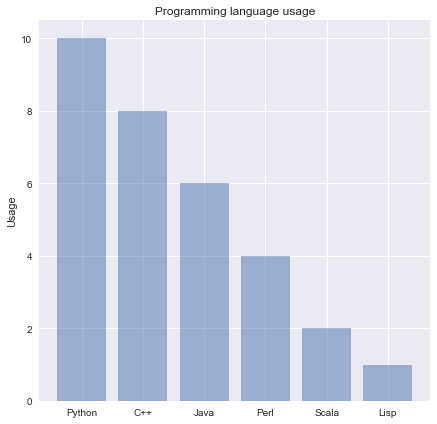

In [162]:
objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()

In [14]:
def login_successful(data):
    return data['Commands'].apply(lambda x: x=='Attack')

In [9]:
n = 626
for i in range(n,n+1):
    print(ip_data[i])
    print(len(ip_data[i][6]))

['2016-07-05 06:20:16', '77.28.79.246', '8807', '133.34.157.104', '23', ['root', 'root'], ['sh', 'shell', 'enable', 'UDSWU(STzDwTISTu*UTIZ?=STzDwSddS?=STu*UTSddS?=ST=)uTxADZ^vxs^!qSr|)zSAzzw1TT+@X@@@X', '', 'X@>$T^B"XxAZxAS^B"XxAZ^vxs^!qS(zw|)zSWvS*"!"sD!vxSWwS*"!"sD!vxS+@X@@@X', '', 'X@>$S^B"@XxAS^B"@XxAZxAS^B"@XxAZ^vxs^!qSz(zwSWUS^B"oXxASW|S+@X@@@X', '', 'X@>$ZxAS^B"oXxA', 'UDSWU(STzDwTISTu*UTIZ?=STzDwSddS?=STu*UTSddS?=ST=)uTxADZ^vxs^!qSr|)zSAzzw1TT+@X@@@X', '', 'X@>$T^B"XxAZxAS^B"XxAZ^vxs^!qS(zw|)zSWvS*"!"sD!vxSWwS*"!"sD!vxS+@X@@@X', '', 'X@>$S^B"@XxAS^B"@XxAZxAS^B"@XxAZ^vxs^!qSz(zwSWUS^B"oXxASW|S+@X@@@X', '', 'X@>$ZxAS^B"oXxA', 'UDSWU(STzDwTISTu*UTIZ?=STzDwSddS?=STu*UTSddS?=ST=)uTxADZ^vxs^!qSr|)zSAzzw1TT+@X@@@X', '', 'X@>$T^B"XxAZxAS^B"XxAZ^vxs^!qS(zw|)zSWvS*"!"sD!vxSWwS*"!"sD!vxS+@X@@@X', '', 'X@>$S^B"@XxAS^B"@XxAZxAS^B"@XxAZ^vxs^!qSz(zwSWUS^B"oXxASW|S+@X@@@X', '', 'X@>$ZxAS^B"oXxA', 'UDSWU(STzDwTISTu*UTIZ?=STzDwSddS?=STu*UTSddS?=ST=)uTxADZ^vxs^!qSr|)zSAzzw1TT+@X@@@X', '', 'X@>$T^